In [164]:
import numpy as np
import math
import random 
import itertools
import pandas as pd
from numpy import linalg as LA
from sklearn import datasets
from fancyimpute import SoftImpute, IterativeImputer, BiScaler
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [65]:
#https://www.kaggle.com/prajitdatta/movielens-100k-dataset
df = pd.read_csv("ratings_2018.csv")

In [66]:
df.shape

(100836, 4)

In [67]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [68]:
# creating utility matrix.
index=list(df['userId'].unique())
columns=list(df['movieId'].unique())
index=sorted(index)
columns=sorted(columns)
 
util_df=pd.pivot_table(data=df,values='rating',index='userId',columns='movieId')
# Nan implies that user has not rated the corressponding movie.

In [69]:
util_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
#count number of movies per user rated
util_df['full_count'] = util_df.apply(lambda x: x.count(), axis=1)

In [72]:
util_df.sort_values(by=['full_count'], ascending=False).head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193567,193571,193573,193579,193581,193583,193585,193587,193609,full_count
userId,,,,,,,,,,,,,,,,,,,,,
414,4.0,3.0,4.0,NaN,2.0,3.0,3.0,3.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2698
599,3.0,2.5,1.5,NaN,NaN,4.5,2.5,NaN,1.5,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2478
474,4.0,3.0,NaN,NaN,1.5,3.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2108
448,5.0,3.0,3.0,NaN,3.0,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1864
274,4.0,3.5,NaN,NaN,NaN,4.0,NaN,3.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1346


In [73]:
util_movie = util_df.drop(columns=['full_count']).T

In [74]:
util_movie.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
util_movie.shape

(9724, 610)

In [76]:
# count number of ratings per movie
util_movie['full_count_movie'] = util_movie.apply(lambda x: x.count(), axis=1)

In [78]:
#top 100 most rated movie index
movietop100 = util_movie.sort_values(by=['full_count_movie'], ascending=False).index[0:100].tolist()

In [127]:
#subset 100 users who rated most movies and the most rated top 100 movies 
# train/test split
#convert to 2D numpy array
y_top100user = util_df.sort_values(by=['full_count'], ascending=False).head(100)

In [128]:
y=y_top100user.loc[:,movietop100]

In [130]:
#missing %
y = np.array(y)
np.isnan(y).sum()/np.prod(y.shape)

0.3777

In [132]:
# train test split!
index_12 = np.where(~np.isnan(y))
idx = np.random.choice(np.arange(len(index_12[0])), 1000, replace=False) #use 1000 datapoints as hold-out
row_idx = index_12[0][idx]
col_idx = index_12[1][idx]
y_train = np.copy(y)
y_train[row_idx, col_idx] = np.nan

In [133]:
np.isnan(y_train).sum()/np.prod(y.shape)

0.4777

## Algorithm
- nuclear norm minimization (softimpute)
- multiple imputation
- softimpute + mask

** Evaluation: test error = (yfill - y)^2/||y|| on the missing entries & normalize different missing entries)

### Softimpute

In [182]:
# Softimpute on real matrix (guess NMAR), with different rank k
test_errs = []
for k in range(1,10):
    biscaler = BiScaler()
    y_s = biscaler.fit_transform(y_train)  #standardized to row/col with mean 0 and var =1
    y_softimpute = SoftImpute(max_rank=k).fit_transform(y_s)
    # recover the original matrix
    y_original =  biscaler.inverse_transform(y_softimpute)
    test_error = ( LA.norm(y[row_idx, col_idx]  - y_original[row_idx, col_idx])  /  LA.norm(y[row_idx, col_idx]) ) **2
    #mse = ((y_original[row_idx, col_idx]-y[row_idx, col_idx]) ** 2).mean()
    test_errs.append(test_error)

[BiScaler] Initial log residual value = 8.008414
[BiScaler] Iter 1: log residual = -0.677419, log improvement ratio=8.685833
[BiScaler] Iter 2: log residual = -4.472549, log improvement ratio=3.795130
[BiScaler] Iter 3: log residual = -7.970904, log improvement ratio=3.498355
[BiScaler] Iter 4: log residual = -11.274490, log improvement ratio=3.303586
[BiScaler] Iter 5: log residual = -14.467869, log improvement ratio=3.193379
[BiScaler] Iter 6: log residual = -17.580779, log improvement ratio=3.112910
[BiScaler] Iter 7: log residual = -20.627898, log improvement ratio=3.047119
[BiScaler] Iter 8: log residual = -23.623312, log improvement ratio=2.995414
[BiScaler] Iter 9: log residual = -26.578077, log improvement ratio=2.954765
[BiScaler] Iter 10: log residual = -29.499365, log improvement ratio=2.921288
[BiScaler] Iter 11: log residual = -32.391525, log improvement ratio=2.892160
[BiScaler] Iter 12: log residual = -35.257358, log improvement ratio=2.865833
[BiScaler] Iter 13: log res

[SoftImpute] Iter 61: observed MAE=0.689954 rank=3
[SoftImpute] Iter 62: observed MAE=0.689945 rank=3
[SoftImpute] Iter 63: observed MAE=0.689932 rank=3
[SoftImpute] Iter 64: observed MAE=0.689917 rank=3
[SoftImpute] Iter 65: observed MAE=0.689903 rank=3
[SoftImpute] Iter 66: observed MAE=0.689889 rank=3
[SoftImpute] Iter 67: observed MAE=0.689874 rank=3
[SoftImpute] Iter 68: observed MAE=0.689858 rank=3
[SoftImpute] Iter 69: observed MAE=0.689838 rank=3
[SoftImpute] Iter 70: observed MAE=0.689815 rank=3
[SoftImpute] Iter 71: observed MAE=0.689796 rank=3
[SoftImpute] Iter 72: observed MAE=0.689774 rank=3
[SoftImpute] Iter 73: observed MAE=0.689753 rank=3
[SoftImpute] Iter 74: observed MAE=0.689733 rank=3
[SoftImpute] Iter 75: observed MAE=0.689718 rank=3
[SoftImpute] Iter 76: observed MAE=0.689704 rank=3
[SoftImpute] Iter 77: observed MAE=0.689691 rank=3
[SoftImpute] Iter 78: observed MAE=0.689677 rank=3
[SoftImpute] Iter 79: observed MAE=0.689662 rank=3
[SoftImpute] Iter 80: observed 

[SoftImpute] Iter 83: observed MAE=0.629663 rank=5
[SoftImpute] Iter 84: observed MAE=0.629658 rank=5
[SoftImpute] Iter 85: observed MAE=0.629653 rank=5
[SoftImpute] Iter 86: observed MAE=0.629647 rank=5
[SoftImpute] Iter 87: observed MAE=0.629641 rank=5
[SoftImpute] Iter 88: observed MAE=0.629635 rank=5
[SoftImpute] Iter 89: observed MAE=0.629628 rank=5
[SoftImpute] Iter 90: observed MAE=0.629621 rank=5
[SoftImpute] Iter 91: observed MAE=0.629613 rank=5
[SoftImpute] Iter 92: observed MAE=0.629606 rank=5
[SoftImpute] Iter 93: observed MAE=0.629598 rank=5
[SoftImpute] Iter 94: observed MAE=0.629590 rank=5
[SoftImpute] Iter 95: observed MAE=0.629583 rank=5
[SoftImpute] Iter 96: observed MAE=0.629576 rank=5
[SoftImpute] Iter 97: observed MAE=0.629569 rank=5
[SoftImpute] Iter 98: observed MAE=0.629561 rank=5
[SoftImpute] Iter 99: observed MAE=0.629552 rank=5
[SoftImpute] Iter 100: observed MAE=0.629542 rank=5
[SoftImpute] Stopped after iteration 100 for lambda=0.348809
[BiScaler] Initial l

[SoftImpute] Iter 61: observed MAE=0.574267 rank=7
[SoftImpute] Iter 62: observed MAE=0.574231 rank=7
[SoftImpute] Iter 63: observed MAE=0.574197 rank=7
[SoftImpute] Iter 64: observed MAE=0.574162 rank=7
[SoftImpute] Iter 65: observed MAE=0.574127 rank=7
[SoftImpute] Iter 66: observed MAE=0.574091 rank=7
[SoftImpute] Iter 67: observed MAE=0.574059 rank=7
[SoftImpute] Iter 68: observed MAE=0.574028 rank=7
[SoftImpute] Iter 69: observed MAE=0.574001 rank=7
[SoftImpute] Iter 70: observed MAE=0.573975 rank=7
[SoftImpute] Iter 71: observed MAE=0.573950 rank=7
[SoftImpute] Iter 72: observed MAE=0.573925 rank=7
[SoftImpute] Iter 73: observed MAE=0.573899 rank=7
[SoftImpute] Iter 74: observed MAE=0.573875 rank=7
[SoftImpute] Iter 75: observed MAE=0.573850 rank=7
[SoftImpute] Iter 76: observed MAE=0.573825 rank=7
[SoftImpute] Iter 77: observed MAE=0.573801 rank=7
[SoftImpute] Iter 78: observed MAE=0.573778 rank=7
[SoftImpute] Iter 79: observed MAE=0.573756 rank=7
[SoftImpute] Iter 80: observed 

[SoftImpute] Iter 14: observed MAE=0.530683 rank=9
[SoftImpute] Iter 15: observed MAE=0.529932 rank=9
[SoftImpute] Iter 16: observed MAE=0.529245 rank=9
[SoftImpute] Iter 17: observed MAE=0.528615 rank=9
[SoftImpute] Iter 18: observed MAE=0.528033 rank=9
[SoftImpute] Iter 19: observed MAE=0.527484 rank=9
[SoftImpute] Iter 20: observed MAE=0.526967 rank=9
[SoftImpute] Iter 21: observed MAE=0.526489 rank=9
[SoftImpute] Iter 22: observed MAE=0.526049 rank=9
[SoftImpute] Iter 23: observed MAE=0.525646 rank=9
[SoftImpute] Iter 24: observed MAE=0.525272 rank=9
[SoftImpute] Iter 25: observed MAE=0.524918 rank=9
[SoftImpute] Iter 26: observed MAE=0.524575 rank=9
[SoftImpute] Iter 27: observed MAE=0.524256 rank=9
[SoftImpute] Iter 28: observed MAE=0.523958 rank=9
[SoftImpute] Iter 29: observed MAE=0.523689 rank=9
[SoftImpute] Iter 30: observed MAE=0.523439 rank=9
[SoftImpute] Iter 31: observed MAE=0.523204 rank=9
[SoftImpute] Iter 32: observed MAE=0.522996 rank=9
[SoftImpute] Iter 33: observed 

In [183]:
test_errs

[0.038758412427918706,
 0.038980447044413086,
 0.03874409665597448,
 0.0412368897881581,
 0.04293976255656584,
 0.04541156220677045,
 0.049250757802282316,
 0.050900287620487476,
 0.054007601550962556]

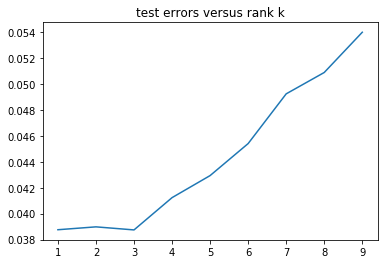

In [184]:
# plot for test_error w.r.t rank
plt.plot(range(1,10), test_errs)
plt.title('test errors versus rank k') 
plt.show()

- rank 3 is the best model

### softImpute with mask concatenation (NMAR)

In [189]:
# function to fit softimpute and compute test error
def soft_mask(y_miss, y_original, k):
    biscaler = BiScaler()
    ncol = np.shape(y_original)[1]
    mask = np.isnan(y_miss).astype(int)
    y_input_s = biscaler.fit_transform(y_miss) 
    y_input = np.concatenate((y_input_s, mask), axis=1)
    y_MCAR_softimpute = SoftImpute(max_rank=k).fit_transform(y_input)
    y_MCAR_original = biscaler.inverse_transform(y_MCAR_softimpute[:,0:ncol])
    #print(y_input.shape, y_MCAR_softimpute.shape)
    return y_MCAR_original[:,0:ncol]

In [190]:
y_original_con = soft_mask(y_train, y, 3)

[BiScaler] Initial log residual value = 8.008414
[BiScaler] Iter 1: log residual = -0.677419, log improvement ratio=8.685833
[BiScaler] Iter 2: log residual = -4.472549, log improvement ratio=3.795130
[BiScaler] Iter 3: log residual = -7.970904, log improvement ratio=3.498355
[BiScaler] Iter 4: log residual = -11.274490, log improvement ratio=3.303586
[BiScaler] Iter 5: log residual = -14.467869, log improvement ratio=3.193379
[BiScaler] Iter 6: log residual = -17.580779, log improvement ratio=3.112910
[BiScaler] Iter 7: log residual = -20.627898, log improvement ratio=3.047119
[BiScaler] Iter 8: log residual = -23.623312, log improvement ratio=2.995414
[BiScaler] Iter 9: log residual = -26.578077, log improvement ratio=2.954765
[BiScaler] Iter 10: log residual = -29.499365, log improvement ratio=2.921288
[BiScaler] Iter 11: log residual = -32.391525, log improvement ratio=2.892160
[BiScaler] Iter 12: log residual = -35.257358, log improvement ratio=2.865833
[BiScaler] Iter 13: log res

In [191]:
test_error = ( LA.norm(y[row_idx, col_idx]  - y_original_con[row_idx, col_idx])  /  LA.norm(y[row_idx, col_idx]) ) **2
print("SoftImpute test error on concatenated real: %f" % test_error)

SoftImpute test error on concatenated real: 0.037834


In [192]:
test_errs_con = []
for k in range(1,10):
    y_original_con = soft_mask(y_train, y, k)
    test_error = ( LA.norm(y[row_idx, col_idx]  - y_original_con[row_idx, col_idx])  /  LA.norm(y[row_idx, col_idx]) ) **2
    test_errs_con.append(test_error)

[BiScaler] Initial log residual value = 8.008414
[BiScaler] Iter 1: log residual = -0.677419, log improvement ratio=8.685833
[BiScaler] Iter 2: log residual = -4.472549, log improvement ratio=3.795130
[BiScaler] Iter 3: log residual = -7.970904, log improvement ratio=3.498355
[BiScaler] Iter 4: log residual = -11.274490, log improvement ratio=3.303586
[BiScaler] Iter 5: log residual = -14.467869, log improvement ratio=3.193379
[BiScaler] Iter 6: log residual = -17.580779, log improvement ratio=3.112910
[BiScaler] Iter 7: log residual = -20.627898, log improvement ratio=3.047119
[BiScaler] Iter 8: log residual = -23.623312, log improvement ratio=2.995414
[BiScaler] Iter 9: log residual = -26.578077, log improvement ratio=2.954765
[BiScaler] Iter 10: log residual = -29.499365, log improvement ratio=2.921288
[BiScaler] Iter 11: log residual = -32.391525, log improvement ratio=2.892160
[BiScaler] Iter 12: log residual = -35.257358, log improvement ratio=2.865833
[BiScaler] Iter 13: log res

[BiScaler] Iter 18: log residual = -51.997103, log improvement ratio=2.742586
[BiScaler] Iter 19: log residual = -54.723044, log improvement ratio=2.725941
[BiScaler] Iter 20: log residual = -57.433847, log improvement ratio=2.710803
[BiScaler] Iter 21: log residual = -60.128936, log improvement ratio=2.695088
[BiScaler] Iter 22: log residual = -62.586297, log improvement ratio=2.457362
[BiScaler] Iter 23: log residual = -64.009901, log improvement ratio=1.423603
[BiScaler] Iter 24: log residual = -64.318010, log improvement ratio=0.308109
[BiScaler] Iter 25: log residual = -64.403647, log improvement ratio=0.085637
[BiScaler] Iter 26: log residual = -64.310537, log improvement ratio=-0.093111
[SoftImpute] Max Singular Value of X_init = 51.553160
[SoftImpute] Iter 1: observed MAE=0.505810 rank=4
[SoftImpute] Iter 2: observed MAE=0.499417 rank=4
[SoftImpute] Iter 3: observed MAE=0.496934 rank=4
[SoftImpute] Iter 4: observed MAE=0.495550 rank=4
[SoftImpute] Iter 5: observed MAE=0.494713 

[SoftImpute] Iter 3: observed MAE=0.474284 rank=6
[SoftImpute] Iter 4: observed MAE=0.472182 rank=6
[SoftImpute] Iter 5: observed MAE=0.470869 rank=6
[SoftImpute] Iter 6: observed MAE=0.469948 rank=6
[SoftImpute] Iter 7: observed MAE=0.469281 rank=6
[SoftImpute] Iter 8: observed MAE=0.468785 rank=6
[SoftImpute] Iter 9: observed MAE=0.468402 rank=6
[SoftImpute] Iter 10: observed MAE=0.468102 rank=6
[SoftImpute] Iter 11: observed MAE=0.467854 rank=6
[SoftImpute] Iter 12: observed MAE=0.467640 rank=6
[SoftImpute] Iter 13: observed MAE=0.467451 rank=6
[SoftImpute] Iter 14: observed MAE=0.467281 rank=6
[SoftImpute] Iter 15: observed MAE=0.467133 rank=6
[SoftImpute] Iter 16: observed MAE=0.467002 rank=6
[SoftImpute] Iter 17: observed MAE=0.466885 rank=6
[SoftImpute] Iter 18: observed MAE=0.466777 rank=6
[SoftImpute] Iter 19: observed MAE=0.466681 rank=6
[SoftImpute] Iter 20: observed MAE=0.466593 rank=6
[SoftImpute] Iter 21: observed MAE=0.466513 rank=6
[SoftImpute] Iter 22: observed MAE=0.4

[BiScaler] Iter 23: log residual = -64.009901, log improvement ratio=1.423603
[BiScaler] Iter 24: log residual = -64.318010, log improvement ratio=0.308109
[BiScaler] Iter 25: log residual = -64.403647, log improvement ratio=0.085637
[BiScaler] Iter 26: log residual = -64.310537, log improvement ratio=-0.093111
[SoftImpute] Max Singular Value of X_init = 51.553160
[SoftImpute] Iter 1: observed MAE=0.470537 rank=8
[SoftImpute] Iter 2: observed MAE=0.457782 rank=8
[SoftImpute] Iter 3: observed MAE=0.452125 rank=8
[SoftImpute] Iter 4: observed MAE=0.448795 rank=8
[SoftImpute] Iter 5: observed MAE=0.446630 rank=8
[SoftImpute] Iter 6: observed MAE=0.445107 rank=8
[SoftImpute] Iter 7: observed MAE=0.443982 rank=8
[SoftImpute] Iter 8: observed MAE=0.443111 rank=8
[SoftImpute] Iter 9: observed MAE=0.442445 rank=8
[SoftImpute] Iter 10: observed MAE=0.441928 rank=8
[SoftImpute] Iter 11: observed MAE=0.441519 rank=8
[SoftImpute] Iter 12: observed MAE=0.441191 rank=8
[SoftImpute] Iter 13: observed

[SoftImpute] Iter 65: observed MAE=0.426867 rank=9
[SoftImpute] Iter 66: observed MAE=0.426862 rank=9
[SoftImpute] Iter 67: observed MAE=0.426857 rank=9
[SoftImpute] Iter 68: observed MAE=0.426852 rank=9
[SoftImpute] Iter 69: observed MAE=0.426846 rank=9
[SoftImpute] Iter 70: observed MAE=0.426841 rank=9
[SoftImpute] Iter 71: observed MAE=0.426834 rank=9
[SoftImpute] Iter 72: observed MAE=0.426829 rank=9
[SoftImpute] Iter 73: observed MAE=0.426823 rank=9
[SoftImpute] Iter 74: observed MAE=0.426818 rank=9
[SoftImpute] Iter 75: observed MAE=0.426812 rank=9
[SoftImpute] Iter 76: observed MAE=0.426807 rank=9
[SoftImpute] Iter 77: observed MAE=0.426802 rank=9
[SoftImpute] Iter 78: observed MAE=0.426798 rank=9
[SoftImpute] Iter 79: observed MAE=0.426794 rank=9
[SoftImpute] Iter 80: observed MAE=0.426790 rank=9
[SoftImpute] Iter 81: observed MAE=0.426787 rank=9
[SoftImpute] Iter 82: observed MAE=0.426784 rank=9
[SoftImpute] Iter 83: observed MAE=0.426781 rank=9
[SoftImpute] Iter 84: observed 

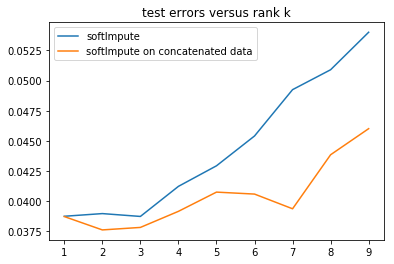

In [196]:
# plot for test_error, test_error_concat w.r.t rank
plt.plot(range(1,10), test_errs, range(1,10), test_errs_con)
plt.title('test errors versus rank k')
plt.legend(['softImpute', 'softImpute on concatenated data'], loc='upper left')
plt.show()

- after concatenating the mask, NMAR has slightly better performance 

### Multiple imputation

In [201]:
#NMAR
n_imputations = 20
XY_completed = []
for i in range(n_imputations):
    imputer = IterativeImputer(n_iter=5, sample_posterior=True, random_state=i)
    XY_completed.append(imputer.fit_transform(y_train))

NMAR_completed_mean = np.mean(XY_completed, 0) #mean of the imputed matrix
NMAR_completed_std = np.std(XY_completed, 0)
test_error_MI = ( LA.norm(y[row_idx, col_idx]  - NMAR_completed_mean[row_idx, col_idx])  /  LA.norm(y[row_idx, col_idx]) ) **2
print("Multiple Imputation test error on NMAR: %f" % test_error_MI)

Multiple Imputation test error on NMAR: 0.039717


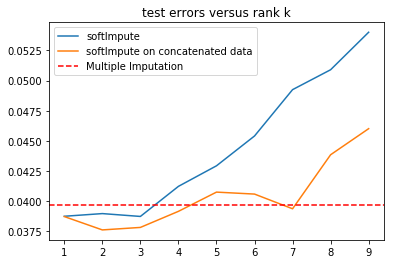

In [202]:
# plot for test_error, test_error_concat w.r.t rank
plt.plot(range(1,10), test_errs, range(1,10), test_errs_con)
plt.axhline(y=test_error_MI, color='r', linestyle='--')
plt.title('test errors versus rank k')
plt.legend(['softImpute', 'softImpute on concatenated data','Multiple Imputation'], loc='upper left')
plt.show()

- Multiple imputation can achieve good performance with the trade-off of much longer computation time